In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

Bài Modelling Test như sau:

Hãy sử dụng dữ liệu được cung cấp trong email này (dữ liệu giá và khối
lượng của một vài mã cổ phiếu) để xây dựng một số mô hình dự đoán biến
động giá cổ phiếu.

Biến động giá cổ phiếu = Giá cổ phiếu N (phút hoặc giờ hoặc ngày) sau - Giá cổ phiếu hiện tại.



In [84]:
df = pd.read_csv('FPT.csv')

In [85]:
df.head()

,Ticker,Date/Time,Open,High,Low,Close,Volume,Open Interest
0,FPT,12/25/2018 9:15,30.89,30.89,30.89,30.89,35410,0
1,FPT,12/25/2018 9:16,30.81,30.81,30.81,30.81,190,0
2,FPT,12/25/2018 9:17,30.74,30.81,30.74,30.74,1120,0
3,FPT,12/25/2018 9:18,30.74,30.74,30.74,30.74,2120,0
4,FPT,12/25/2018 9:19,30.74,30.74,30.74,30.74,22500,0


# TRANSFORM


Chuyển đổi cột 'Date/Time' sang kiểu dữ liệu datetime.

Lọc dữ liệu từ 9h15 đến 14h46.

Thêm một cột mới 'date' để dễ dàng nhóm dữ liệu theo ngày.

Xác định giá Open và Close cho mỗi ngày cho mỗi mã cổ phiếu.

In [86]:
df = pd.DataFrame(df)

# Chuyển đổi cột 'Date/Time' thành kiểu datetime
df['Date/Time'] = pd.to_datetime(df['Date/Time'], format='%m/%d/%Y %H:%M')

print(df.head())

  Ticker           Date/Time   Open   High    Low  Close  Volume  \
0    FPT 2018-12-25 09:15:00  30.89  30.89  30.89  30.89   35410   
1    FPT 2018-12-25 09:16:00  30.81  30.81  30.81  30.81     190   
2    FPT 2018-12-25 09:17:00  30.74  30.81  30.74  30.74    1120   
3    FPT 2018-12-25 09:18:00  30.74  30.74  30.74  30.74    2120   
4    FPT 2018-12-25 09:19:00  30.74  30.74  30.74  30.74   22500   

   Open Interest  
0              0  
1              0  
2              0  
3              0  
4              0  


In [87]:
df.tail()

,Ticker,Date/Time,Open,High,Low,Close,Volume,Open Interest
97401,FPT,2020-12-22 14:24:00,58.2,58.2,58.2,58.2,27470,0
97402,FPT,2020-12-22 14:25:00,58.2,58.2,58.2,58.2,14820,0
97403,FPT,2020-12-22 14:26:00,58.2,58.2,58.2,58.2,500,0
97404,FPT,2020-12-22 14:29:00,58.1,58.1,58.1,58.1,2500,0
97405,FPT,2020-12-22 14:46:00,58.1,58.1,58.1,58.1,11170,0


In [88]:
# Lọc dữ liệu từ 9h15 đến 14h46
df_filtered = df[(df['Date/Time'].dt.time >= pd.to_datetime('09:15').time()) & 
                 (df['Date/Time'].dt.time <= pd.to_datetime('14:46').time())]

# Tạo một cột ngày để dễ dàng nhóm dữ liệu theo ngày
df_filtered['date'] = df_filtered['Date/Time'].dt.date

# Xác định giá Open và Close cho mỗi ngày
open_close = df_filtered.groupby('date').agg(Open=('Open', 'first'),
                                             Close=('Close', 'last')).reset_index()

print(open_close)


           date   Open  Close
0    2018-12-25  30.89  30.66
1    2018-12-26  31.04  30.89
2    2018-12-27  31.41  31.19
3    2018-12-28  31.34  31.49
4    2019-01-02  31.19  30.74
..          ...    ...    ...
494  2020-12-16  57.20  57.10
495  2020-12-17  56.90  56.50
496  2020-12-18  56.50  56.90
497  2020-12-21  57.30  57.50
498  2020-12-22  57.40  58.10

[499 rows x 3 columns]


In [89]:
N = 1  # 1 ngày

# Tạo một cột date_shifted chứa ngày dịch chuyển N ngày
open_close['date_shifted'] = open_close['date'] + pd.to_timedelta(N, unit='D')

# Merge DataFrame với chính nó để lấy giá Close tại ngày hiện tại và giá Open sau N ngày
open_close_merged = pd.merge(open_close, open_close[['date', 'Open']], left_on='date_shifted', right_on='date', suffixes=('', '_shifted'))

# Tính toán biến động giá
open_close_merged['price_change'] = open_close_merged['Open_shifted'] - open_close_merged['Close']

print(open_close_merged[['date', 'Open', 'date_shifted', 'Open_shifted', 'price_change']])


           date   Open date_shifted date_shifted  Open_shifted  price_change
0    2018-12-25  30.89   2018-12-26   2018-12-26         31.04          0.38
1    2018-12-26  31.04   2018-12-27   2018-12-27         31.41          0.52
2    2018-12-27  31.41   2018-12-28   2018-12-28         31.34          0.15
3    2019-01-02  31.19   2019-01-03   2019-01-03         30.93          0.19
4    2019-01-03  30.93   2019-01-04   2019-01-04         30.29         -0.15
..          ...    ...          ...          ...           ...           ...
387  2020-12-14  57.00   2020-12-15   2020-12-15         57.50          0.30
388  2020-12-15  57.50   2020-12-16   2020-12-16         57.20          0.50
389  2020-12-16  57.20   2020-12-17   2020-12-17         56.90         -0.20
390  2020-12-17  56.90   2020-12-18   2020-12-18         56.50          0.00
391  2020-12-21  57.30   2020-12-22   2020-12-22         57.40         -0.10

[392 rows x 6 columns]


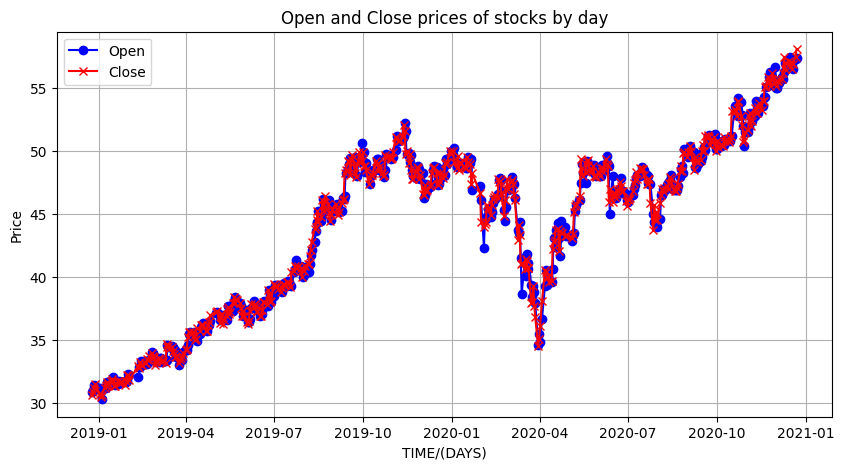

In [110]:
# Vẽ biểu đồ giá Open và Close
plt.figure(figsize=(10, 5))
plt.plot(open_close['date'], open_close['Open'], marker='o', linestyle='-', color='b', label='Open')
plt.plot(open_close['date'], open_close['Close'], marker='x', linestyle='-', color='r', label='Close')

plt.title('Open and Close prices of stocks by day')
plt.xlabel('TIME/(DAYS)')
plt.ylabel('Price')
plt.legend()
plt.grid(True)

plt.show()

# DATA PROCESSING

Xử Lý Dữ Liệu Chuỗi Thời Gian: LSTM (Long Short-Term Memory) là một loại mạng nơ-ron hồi tiếp (RNN) được thiết kế đặc biệt để xử lý dữ liệu chuỗi thời gian, phù hợp cho việc dự đoán giá cổ phiếu dựa trên dữ liệu lịch sử.
Khả Năng Ghi Nhớ Thời Gian Dài: LSTM có khả năng ghi nhớ thông tin trong một khoảng thời gian dài, giúp mô hình hiểu được mối quan hệ giữa các giá trị trong quá khứ và giá trị hiện tại.
Tính Linh Hoạt: LSTM có khả năng học và trích xuất đặc trưng phức tạp từ dữ liệu chuỗi thời gian, giúp cải thiện khả năng dự đoán của mô hình.
Độ Phức Tạp Cao: Mô hình LSTM được chọn với kiến trúc phức tạp bao gồm nhiều lớp LSTM và các lớp kết nối đầy đủ (Dense), giúp mô hình có khả năng học được các mối quan hệ phức tạp trong dữ liệu.


In [91]:
pre = open_close['Close']

pre = pd.DataFrame(pre)

data = pre.values

In [92]:
data.shape

(499, 1)

In [93]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range= (0, 1))
scaled_data = scaler.fit_transform(np.array(data).reshape(-1, 1))

Split DATA

In [94]:
# 75% to Train , 25% to Test
train_size = int(len(data)*.75)
test_size = len(data) - train_size

print("Train Size :",train_size,"Test Size :",test_size)

train_data = scaled_data[ :train_size , 0:1 ]
test_data = scaled_data[ train_size-60: , 0:1 ]

Train Size : 374 Test Size : 125


In [95]:
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

In [96]:
# Convert to numpy array
x_train, y_train = np.array(x_train), np.array(y_train)

In [97]:
# Reshaping the input
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [98]:
x_train.shape , y_train.shape

((314, 60, 1), (314,))

# MODEL 

LSTM

In [99]:
model = Sequential([
    LSTM(50, return_sequences= True, input_shape= (x_train.shape[1], 1)),
    LSTM(64, return_sequences= False),
    Dense(32),
    Dense(16),
    Dense(1)
])

model.compile(optimizer= 'adam', loss= 'mse' , metrics= ["mean_absolute_error"])

In [100]:
tf.keras.utils.plot_model(model,show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [101]:
from keras.callbacks import EarlyStopping
callbacks = [EarlyStopping(monitor= 'loss', patience= 10 , restore_best_weights= True)]
history = model.fit(x_train, y_train, epochs= 50, batch_size= 32 , callbacks= callbacks )

Epoch 1/50
10/10 [==============================] - 5s 42ms/step - loss: 0.0571 - mean_absolute_error: 0.1865
Epoch 2/50
10/10 [==============================] - 1s 54ms/step - loss: 0.0125 - mean_absolute_error: 0.0925
Epoch 3/50
10/10 [==============================] - 0s 41ms/step - loss: 0.0071 - mean_absolute_error: 0.0662
Epoch 4/50
10/10 [==============================] - 0s 38ms/step - loss: 0.0052 - mean_absolute_error: 0.0599
Epoch 5/50
10/10 [==============================] - 0s 42ms/step - loss: 0.0043 - mean_absolute_error: 0.0506
Epoch 6/50
10/10 [==============================] - 0s 36ms/step - loss: 0.0038 - mean_absolute_error: 0.0482
Epoch 7/50
10/10 [==============================] - 0s 37ms/step - loss: 0.0035 - mean_absolute_error: 0.0434
Epoch 8/50
10/10 [==============================] - 0s 37ms/step - loss: 0.0032 - mean_absolute_error: 0.0421
Epoch 9/50
10/10 [==============================] - 0s 37ms/step - loss: 0.0031 - mean_absolute_error: 0.0409
Epoch 10/5

Evaluation

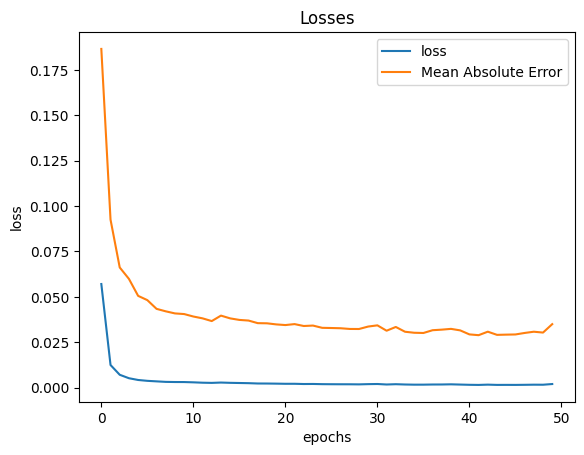

In [102]:
plt.plot(history.history["loss"])
plt.plot(history.history["mean_absolute_error"])
plt.legend(['loss','Mean Absolute Error'])
plt.title("Losses")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

# PREDICTION

In [103]:
# Creating a testing set with 60 time-steps and 1 output
x_test = []
y_test = []

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])
    y_test.append(test_data[i, 0])
x_test, y_test = np.array(x_test), np.array(y_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [104]:
x_test.shape , y_test.shape

((125, 60, 1), (125,))

In [105]:
#inverse y_test scaling
predictions = model.predict(x_test)

#inverse predictions scaling
predictions = scaler.inverse_transform(predictions)
predictions.shape

4/4 [==============================] - 1s 17ms/step


(125, 1)

In [106]:
#inverse y_test scaling
y_test_reshaped = y_test.reshape(-1, 1)  # Reshape y_test thành (n_samples, 1)
y_test_scaled = scaler.inverse_transform(y_test_reshaped)
RMSE = np.sqrt(np.mean((y_test_scaled - predictions)**2)).round(2)
RMSE


1.19

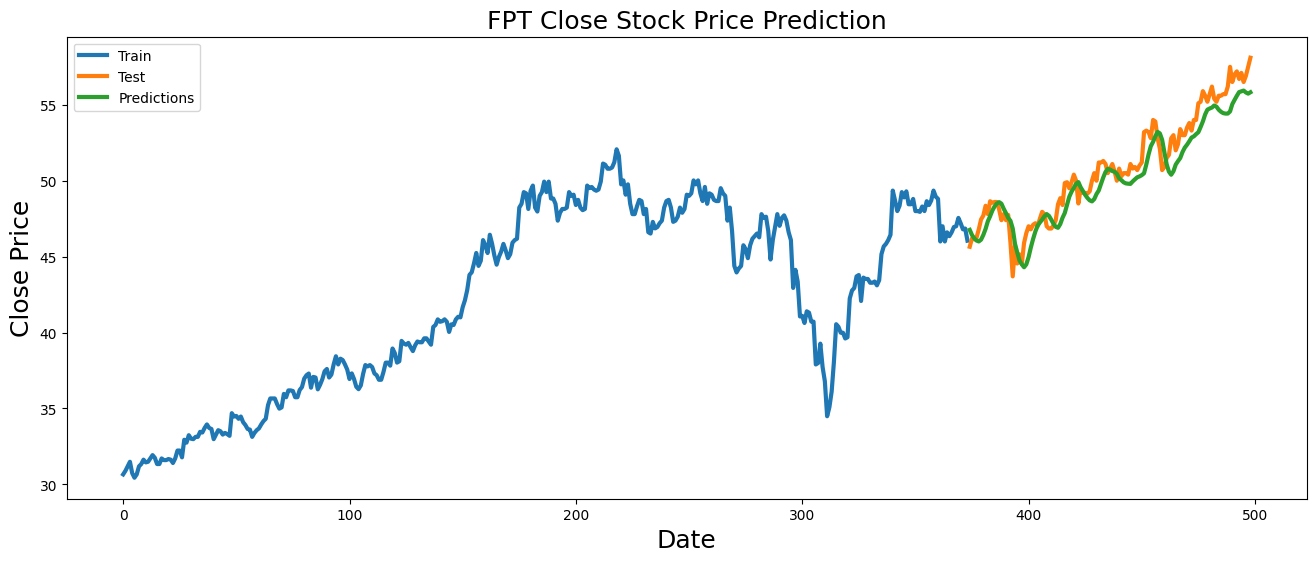

In [109]:
train = pre.iloc[:train_size , 0:1]
test = pre.iloc[train_size: , 0:1]
test['Predictions'] = predictions

plt.figure(figsize= (16, 6))
plt.title('FPT Close Stock Price Prediction', fontsize= 18)
plt.xlabel('Date', fontsize= 18)
plt.ylabel('Close Price', fontsize= 18)
plt.plot(train['Close'], linewidth= 3)
plt.plot(test['Close'], linewidth= 3)
plt.plot(test["Predictions"], linewidth= 3)
plt.legend(['Train', 'Test', 'Predictions'])